---
jupytext:
  cell_metadata_filter: -all
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.11.5
kernelspec:
  display_name: Python 3
  language: python
  name: python3
  

In [42]:
# Install the necessary dependencies

import os
import sys 
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython requests


# Time series

## Overiew

Time series forecasting is a broad field with a long history and forcasting is perhaps the most common application in the real world. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. The understanding of things to come is a pressing need across science, government, and industry (not to mention our personal lives!), and practitioners in these fields are increasingly applying machine learning to address this need.

After finishing this course, you'll know how to:

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

## What is a Time Series?

The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

:::{seealso}
kaggle kernels output ryanholbrook/linear-regression-with-time-series -p /path/to/dest
https://www.kaggle.com/competitions/store-sales-time-series-forecasting
:::

In [43]:
import pandas as pd
df = pd.read_csv(
    "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations $Hardcover$ with a time index $Date$.

## Linear Regression with Time Series

For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:

$target = weight_1 * feature_1 + weight_2 * feature_2 + bias$

During training, the regression algorithm learns values for the parameters $weight_1$, $weight_2$, and $bias$ that best fit the $target$. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

### Time-step features

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

In [44]:
import numpy as np
df['Time'] = np.arange(len(df.index))
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Linear regression with the time dummy produces the model:

$target = weight * time + bias$

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

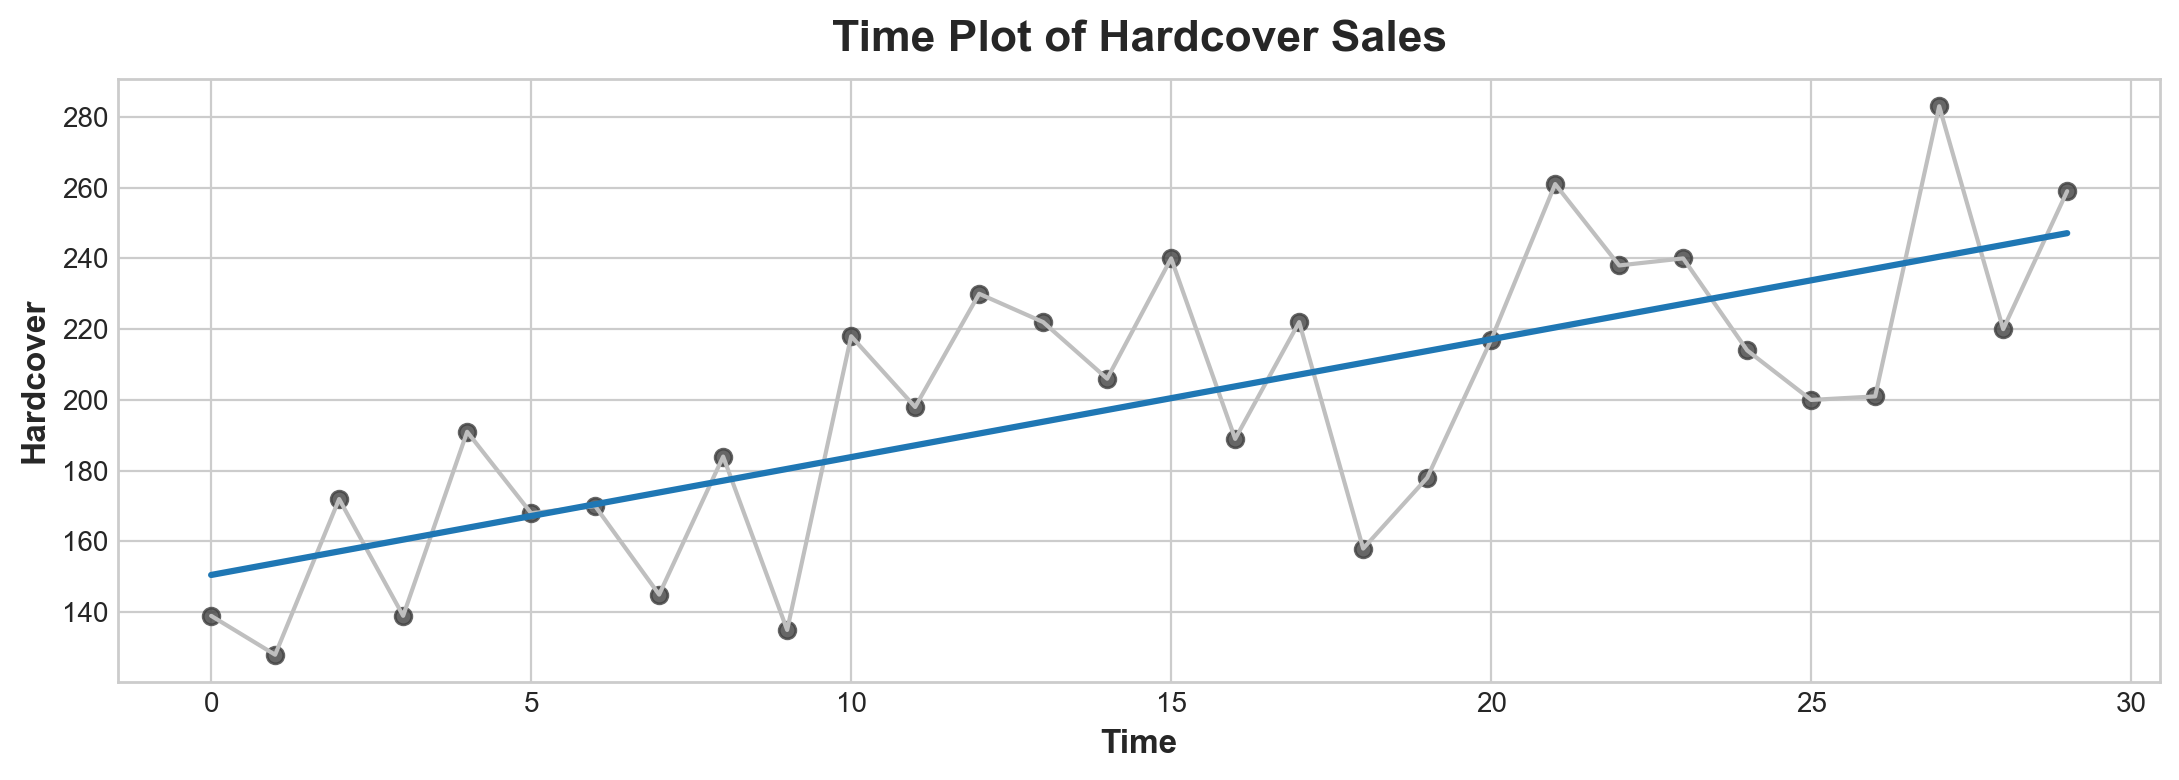

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured. In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.

### Lag features

To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [46]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])
df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model: $target = weight * lag + bias$. So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

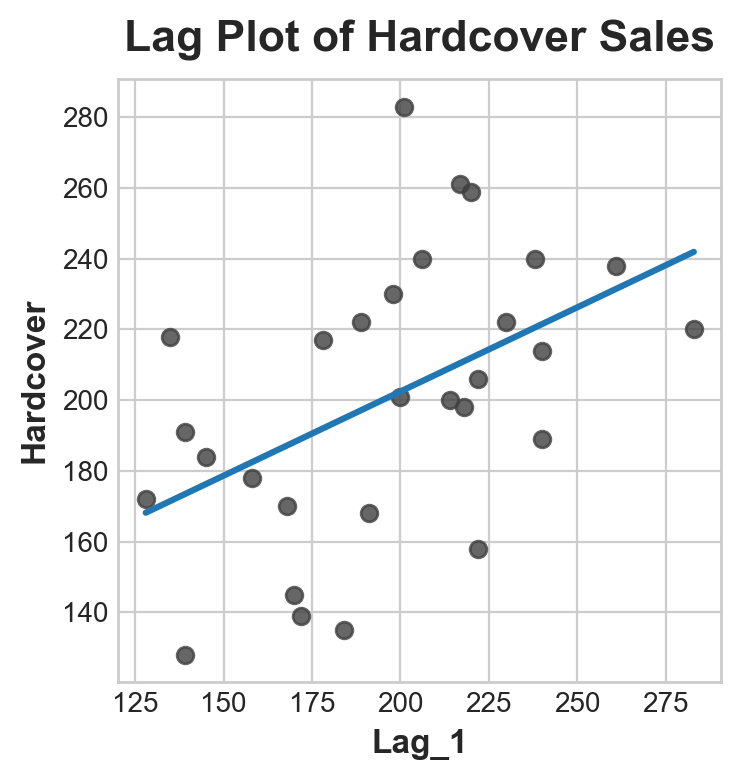

In [47]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day $(Hardcover)$ are correlated with sales from the previous day $(Lag_1)$. When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For most of the course, we use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

## Example - Tunnel Traffic

Tunnel Traffic is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.

In [48]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from io import StringIO

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
cloud_link = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/tunnel.csv"
response = requests.get(cloud_link)
response.raise_for_status()

data = StringIO(response.text)
tunnel = pd.read_csv(data, parse_dates=["Day"])
# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step feature

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [49]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [50]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

The model actually created is (approximately): $Vehicles = 22.5 * Time + 98176$. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

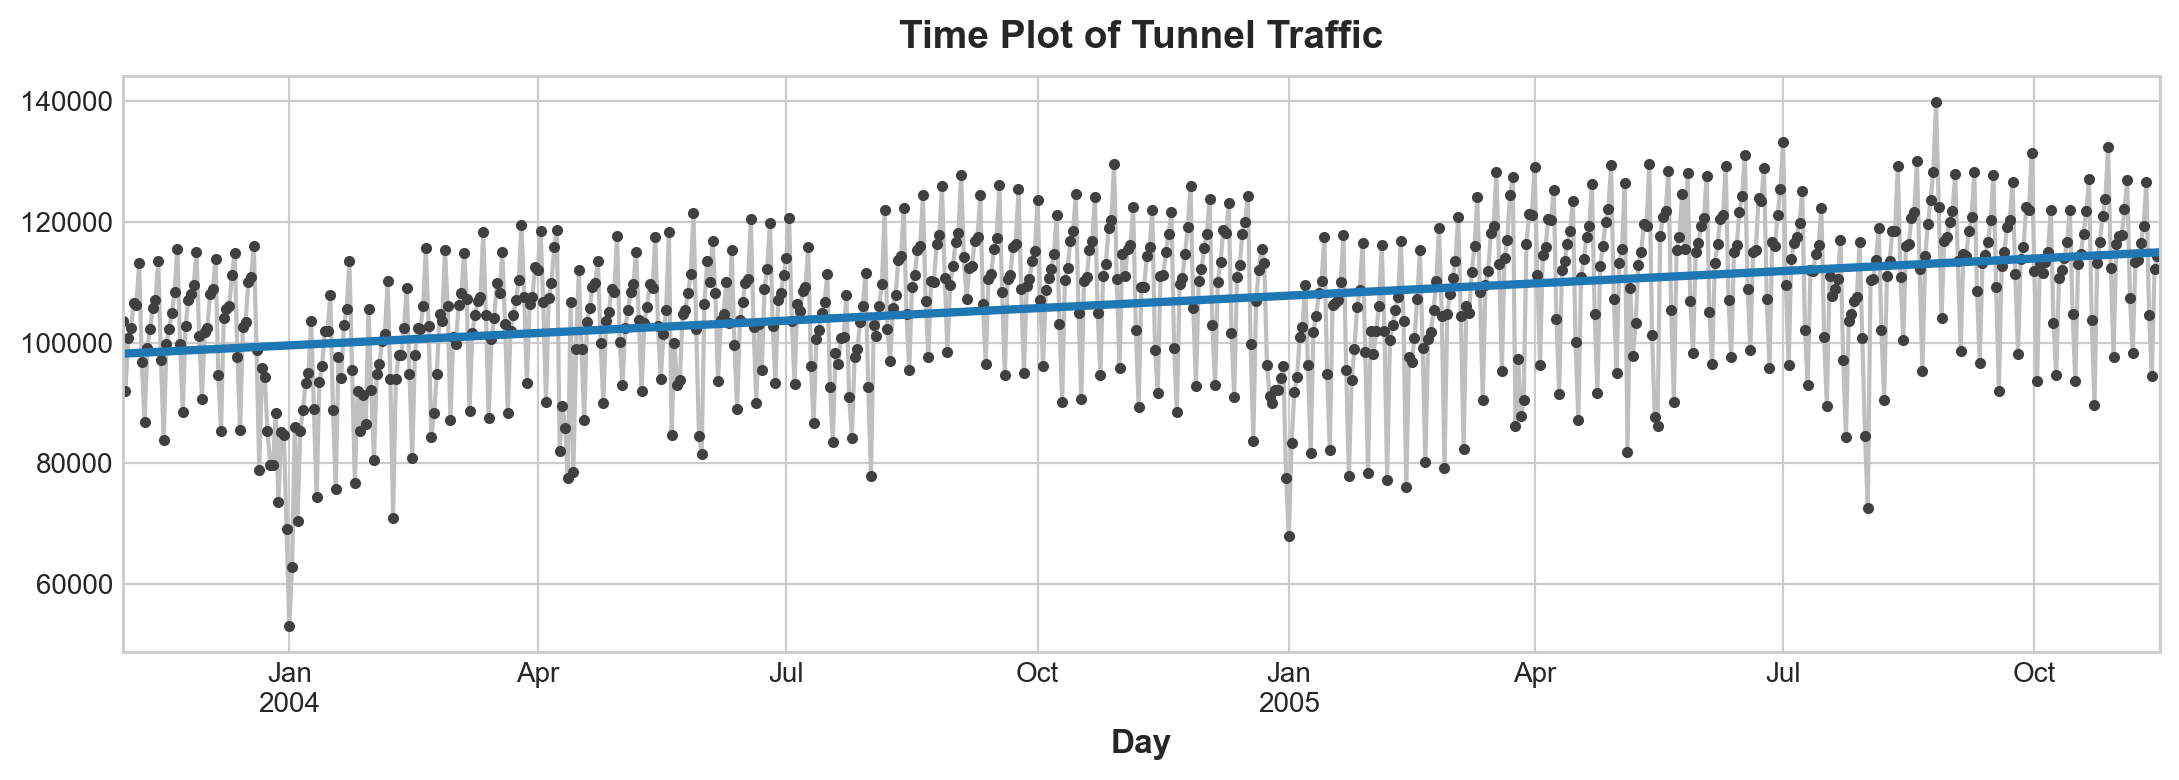

In [51]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

Pandas provides us a simple method to lag a series, the $shift$ method.

In [52]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [53]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

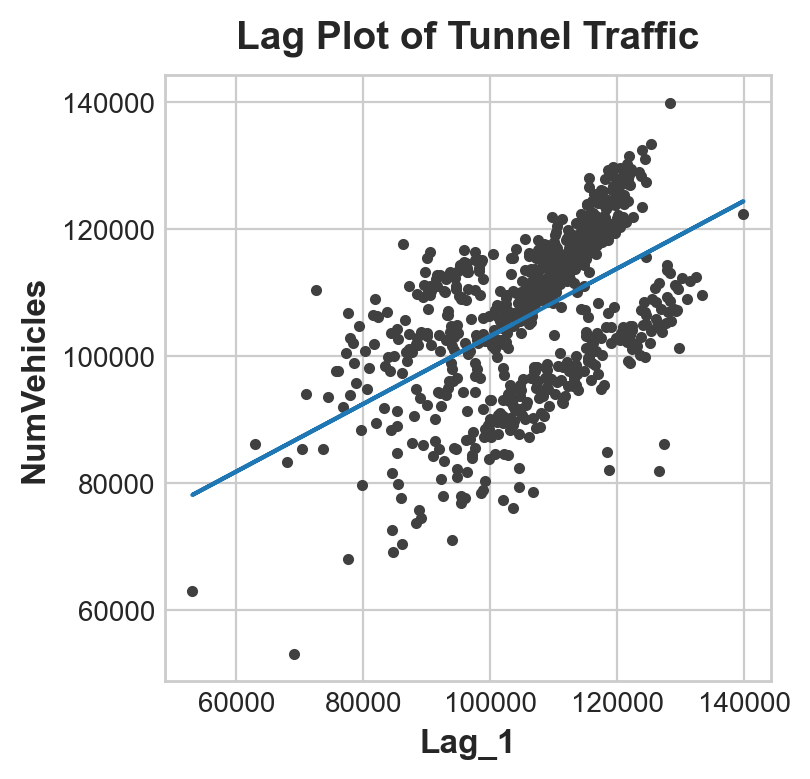

In [54]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

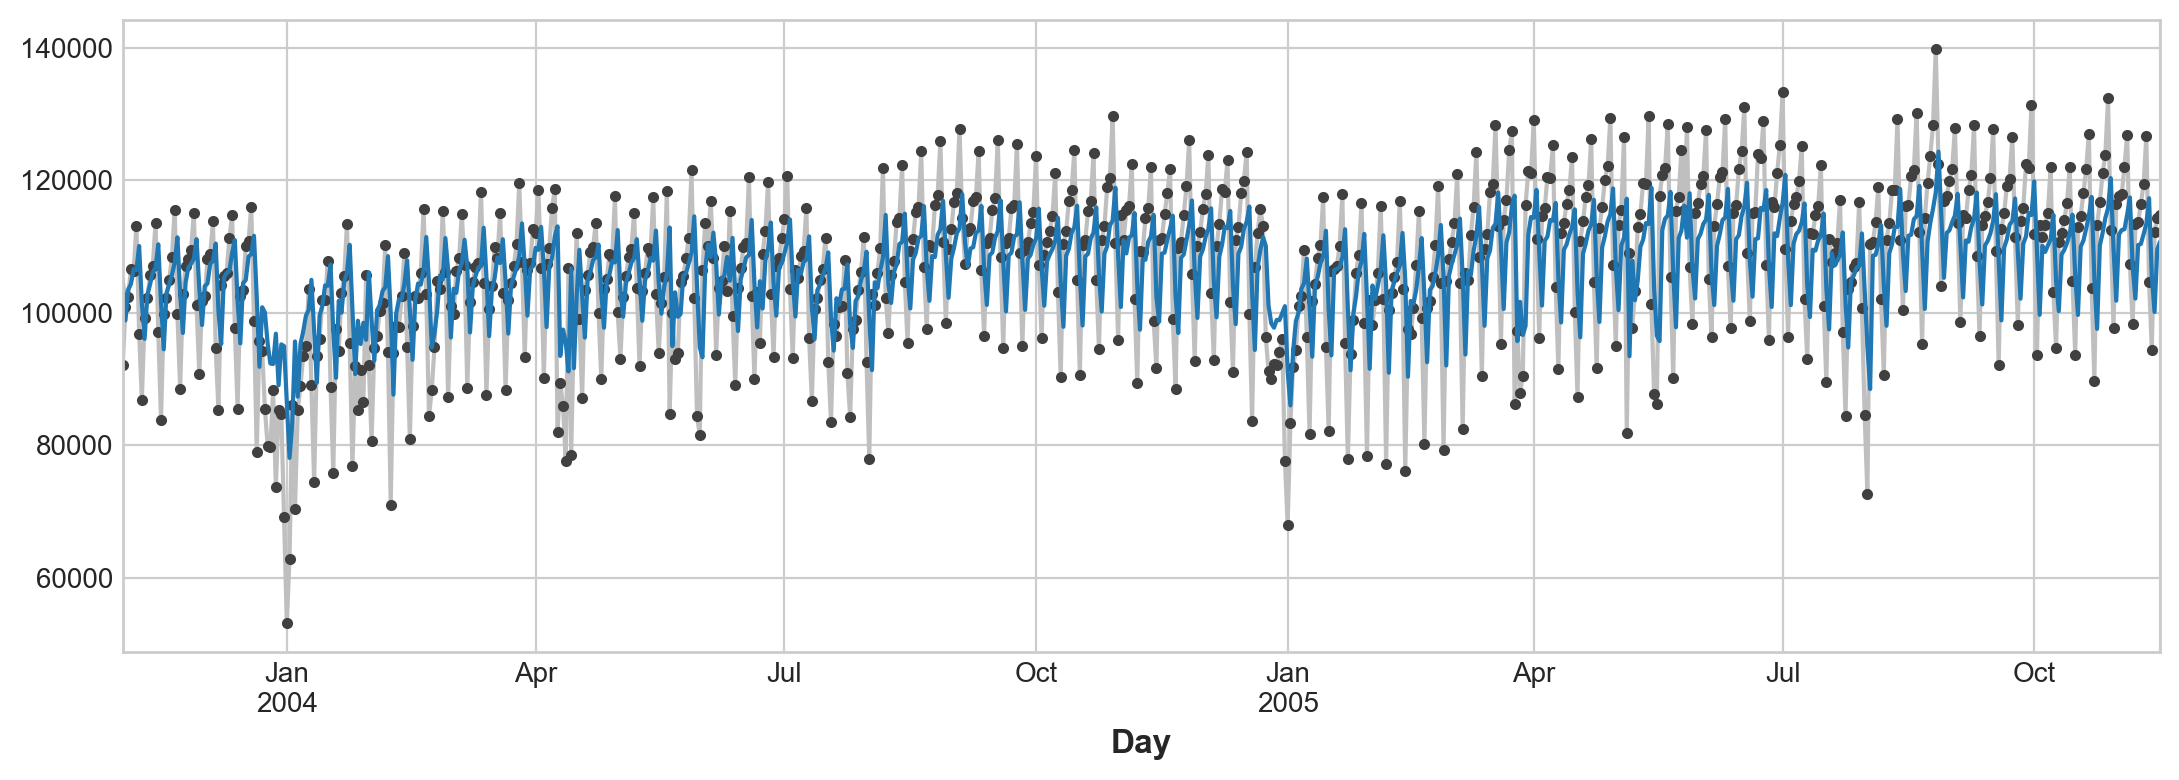

In [55]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of time-step features and lag features. Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.

## Forecasting With Deep Learning

### Defining the Forecasting Task

There are two things to establish before designing a forecasting model:

- what information is available at the time a forecast is made (features),
- the time period during which you require forecasted values (target).

The forecast origin is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

The forecast horizon is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.

:::{figure-md} 01_def
<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/time-series/01_def.png" width="90%" class="bg-white mb-1">

A three-step forecast horizon with a two-step lead time, using four lag features. The figure represents what would be a single row of training data -- data for a single prediction, in other words.
:::

The time between the origin and the horizon is the lead time (or sometimes latency) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

### Preparing Data for Forecasting

In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless, of course, you are only using deterministic features like trend and seasonality.)

We saw the first half of this process in Lesson 4 when we created a feature set out of lags. The second half is preparing the target. How we do this depends on the forecasting task.

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [56]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

The above illustrates how a dataset would be prepared similar to the Defining a Forecast figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is y_step_1. The missing values we could either fill-in or drop.

### Multistep Forecasting Strategies

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

#### Multioutput model

Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

:::{figure-md} 02_multioutput
<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/time-series/02_multioutput.png" width="90%" class="bg-white mb-1">

Multioutput Model
:::

#### Direct strategy

Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

:::{figure-md} 03_direct
<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/time-series/03_direct.png" width="90%" class="bg-white mb-1">

Direct Strategy
:::

#### Recursive strategy

Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

:::{figure-md} 04_recursive
<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/time-series/04_recursive.png" width="90%" class="bg-white mb-1">

Recursive Strategy
:::

#### DirRec strategy

A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

:::{figure-md} 05_dirrec
<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/time-series/05_dirrec.png" width="90%" class="bg-white mb-1">

DirRec Strategy
:::

### Example - Flu Trends

In this example we'll apply the MultiOutput and Direct strategies to the Flu Trends data from Lesson 4, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

The hidden cell sets up the example and defines a helper function $plot_multistep$.

In [57]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


flu_trends = pd.read_csv("https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [58]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

#### Multioutput model

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [59]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 389.12
Test RMSE: 582.33


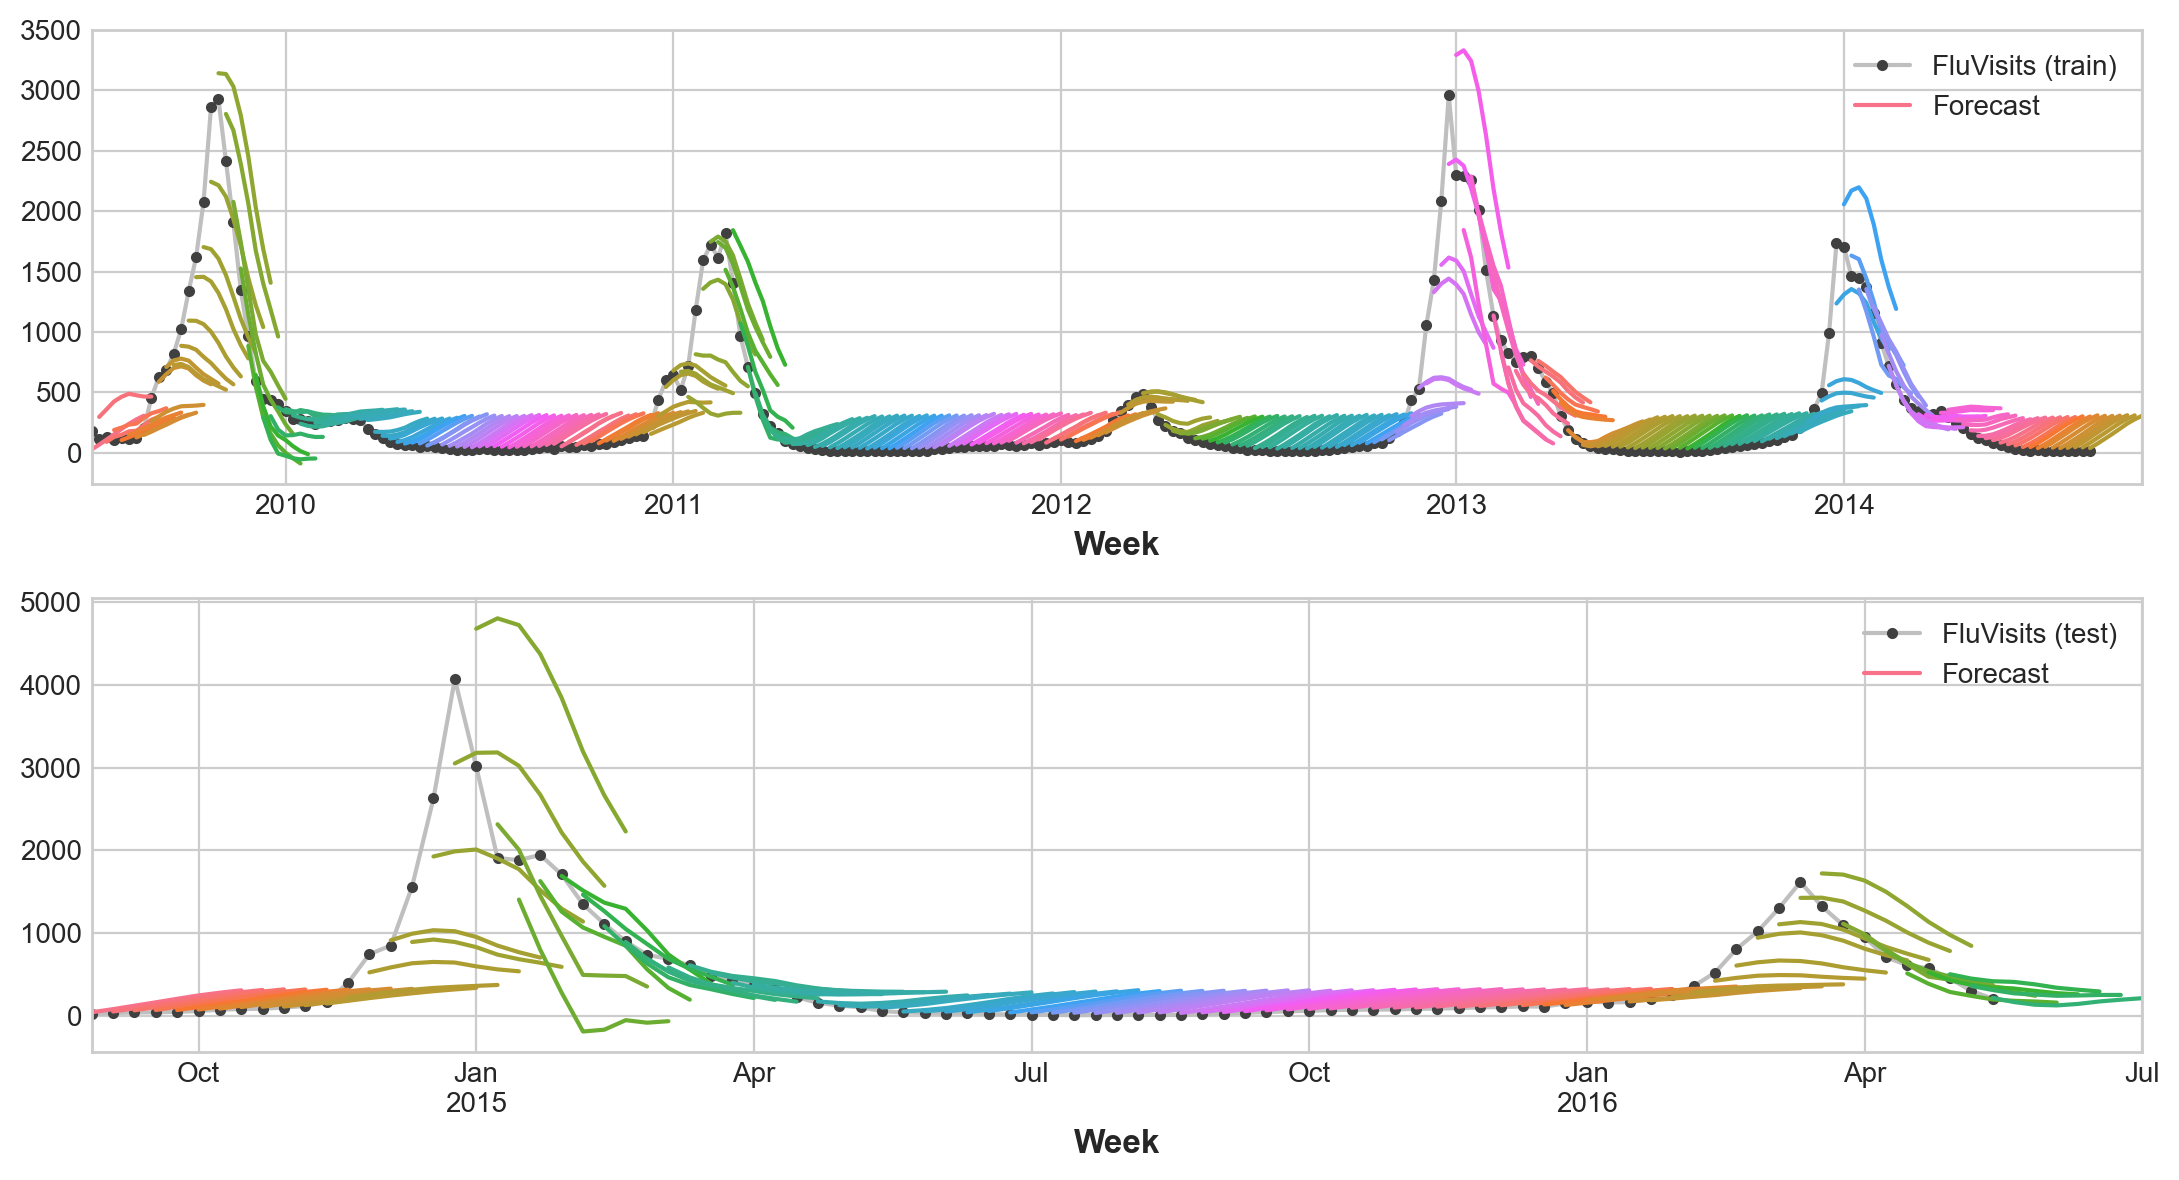

In [60]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

#### Direct strategy

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's $MultiOutputRegressor$.

In [61]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

Train RMSE: 1.22
Test RMSE: 526.45


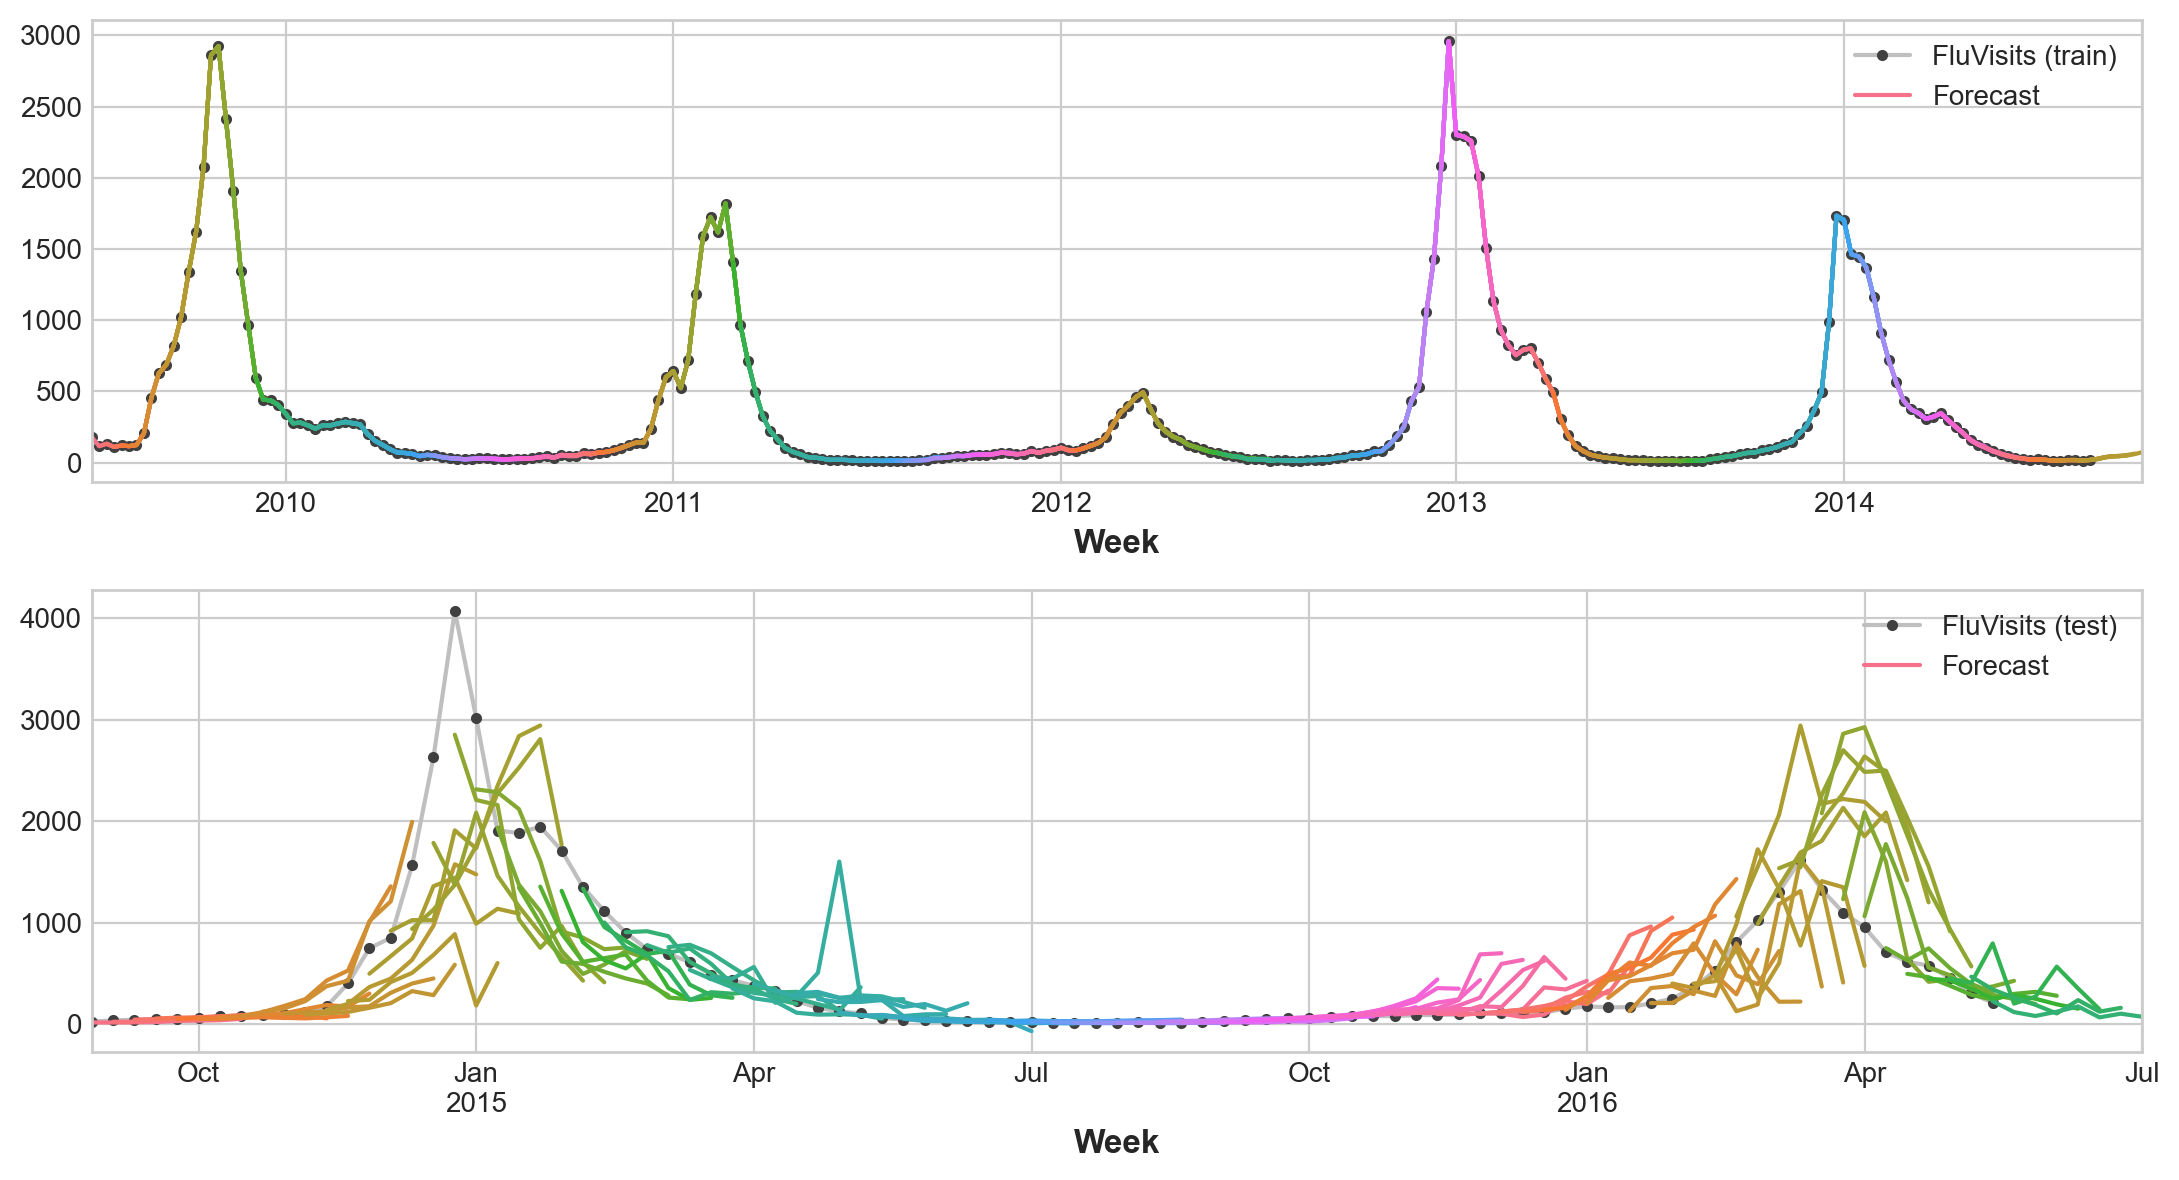

In [62]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace $MultiOutputRegressor$ with another scikit-learn wrapper, $RegressorChain$. The Recursive strategy we would need to code ourselves.

## Your turn! 🚀

TBD.

## Acknowledgments

Thanks to [kaggle](https://www.kaggle.com/) for creating the open-source course [Time Series](https://www.kaggle.com/learn/time-series). It inspires the majority of the content in this chapter.

---

:::{bibliography}
:filter: docname in docnames
:::